# 0.Install




In [1]:
# !pip install torch gpytorch botorch

# 1.Import

In [2]:
import torch
import gpytorch
import botorch
import matplotlib.pyplot as plt
from botorch.test_functions.synthetic import ThreeHumpCamel,Hartmann
from numpy.ma.core import negative
from torch.quasirandom import SobolEngine
from botorch.sampling.normal import SobolQMCNormalSampler

from botorch.models import SingleTaskGP
from botorch.acquisition import qKnowledgeGradient, qLogNoisyExpectedImprovement
from botorch.acquisition.predictive_entropy_search import qPredictiveEntropySearch
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from tqdm.notebook import tqdm
from botorch.models.transforms import Normalize, Standardize
from botorch.optim import optimize_acqf

from gpytorch.means import LinearMean
from gpytorch.kernels import ScaleKernel, RBFKernel
import warnings
import csv

# 2.Test Function: Steep Ridges/Drops: Easom

In [3]:
tkwargs = {
    "dtype": torch.float64,
    "device": torch.device("cuda:0"),
}
d=2
bounds=torch.tensor([[-5.0,-5.0],[5.0,5.0]],**tkwargs)
optimizer =torch.tensor([torch.pi,torch.pi])
optimal_value=-1
noise =0.2
def f5(x,noise):
    x1, x2 = x[..., 0], x[..., 1]
    y = -torch.cos(x1) * torch.cos(x2) * torch.exp(-(x1 - torch.pi)**2 - (x2 - torch.pi)**2)
    y = y + noise*torch.randn_like(y)
    return -y.unsqueeze(-1)
def f(x,noise):
  return f5(x,noise)

# 3.BayesOpt Loop: Easom+qKG+ConstantMean+RBFKernel

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

/home/ziangchen9/miniconda3/envs/CHENYAO/lib/python3.12/site-packages/botorch/optim/initializers.py:545: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  ics = gen_batch_initial_conditions(
/home/ziangchen9/miniconda3/envs/CHENYAO/lib/python3.12/site-packages/botorch/optim/optimize.py:326: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(
/home/ziangchen9/miniconda3/envs/CHENYAO/lib/python3.12/site-packages/botorch/optim/optimize.py:326: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(
/home/ziangchen9/miniconda3/envs/CHENYAO/lib/python3.12/site-packages/botorch/optim/optimize.py:326: BadInitialCandidatesWarning: Unab

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

/home/ziangchen9/miniconda3/envs/CHENYAO/lib/python3.12/site-packages/botorch/optim/optimize.py:326: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(
/home/ziangchen9/miniconda3/envs/CHENYAO/lib/python3.12/site-packages/botorch/optim/optimize.py:326: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(
/home/ziangchen9/miniconda3/envs/CHENYAO/lib/python3.12/site-packages/botorch/optim/optimize.py:326: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(
/home/ziangchen9/miniconda3/envs/CHENYAO/lib/python3.12/site-packages/botorch/optim/optimize.py:326: BadInitialC

  0%|          | 0/80 [00:00<?, ?it/s]

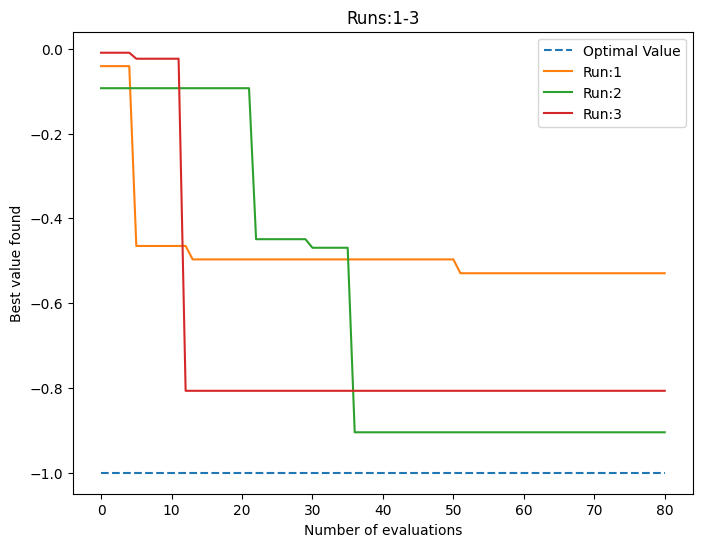

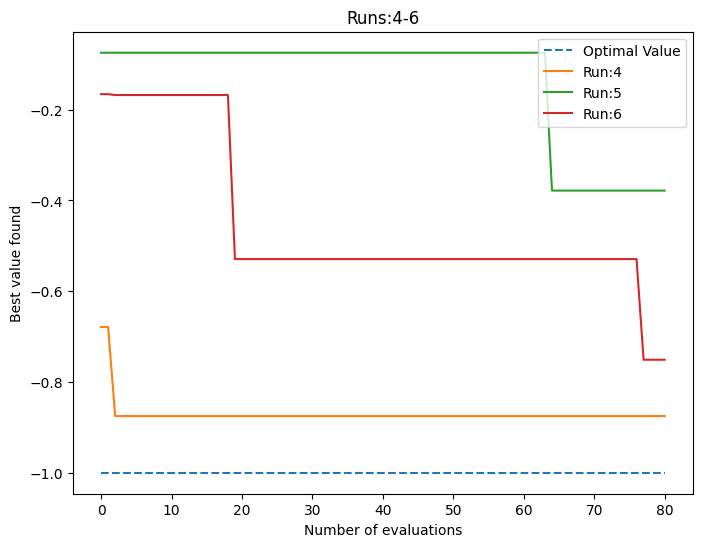

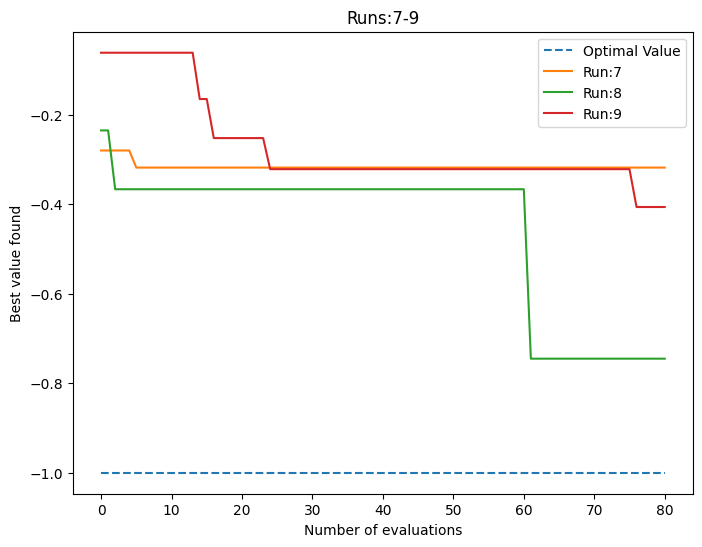

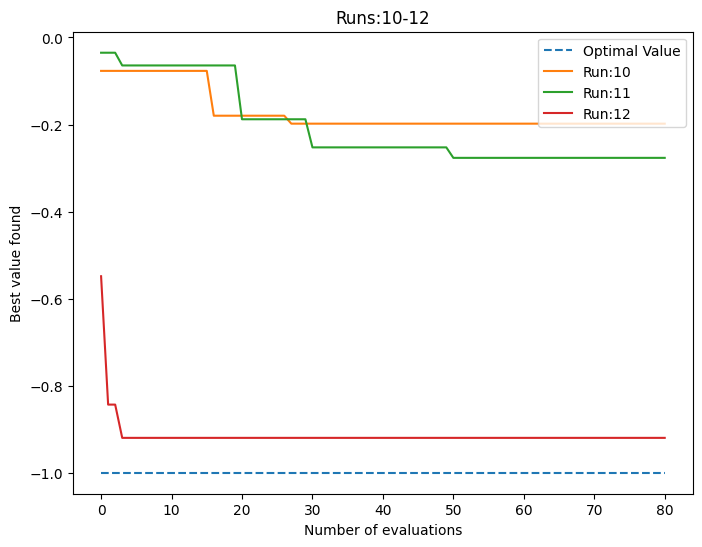

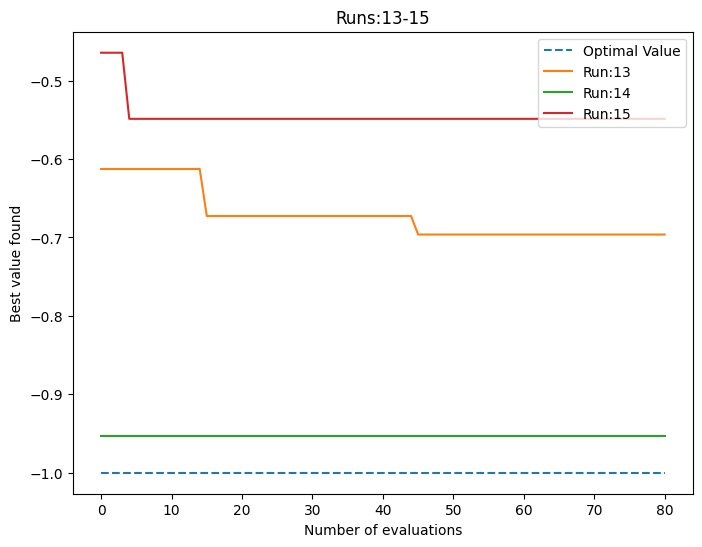

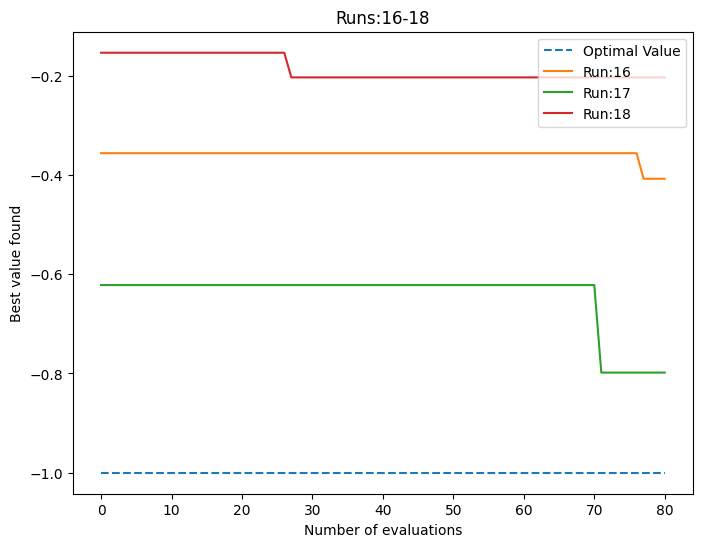

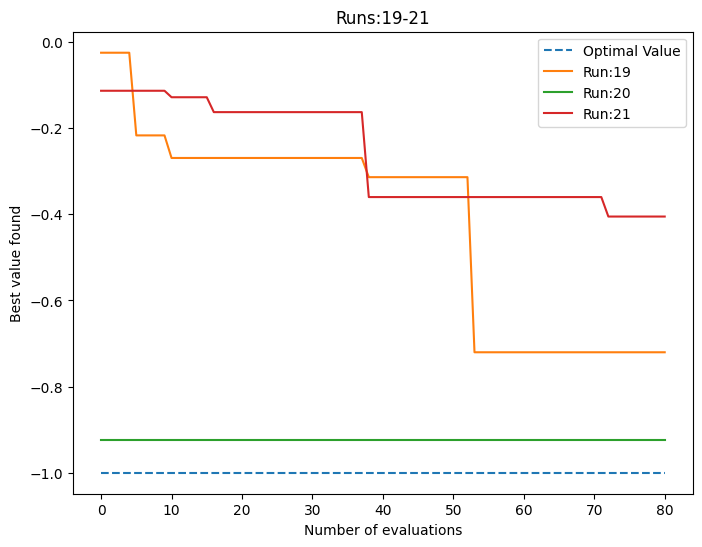

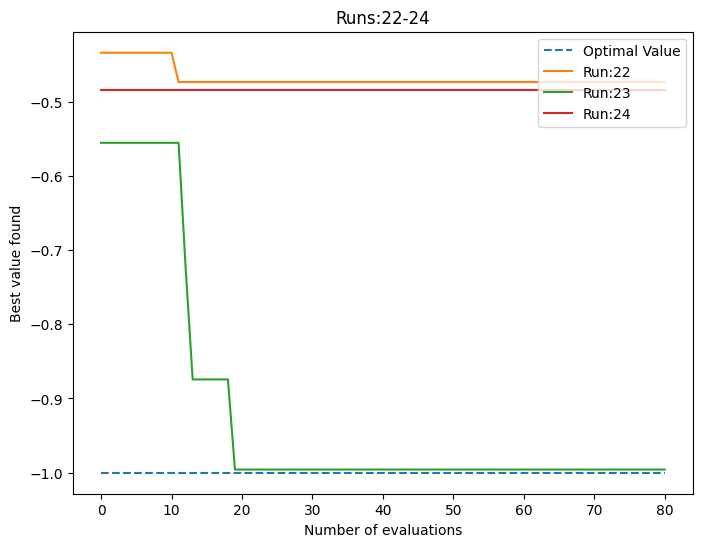

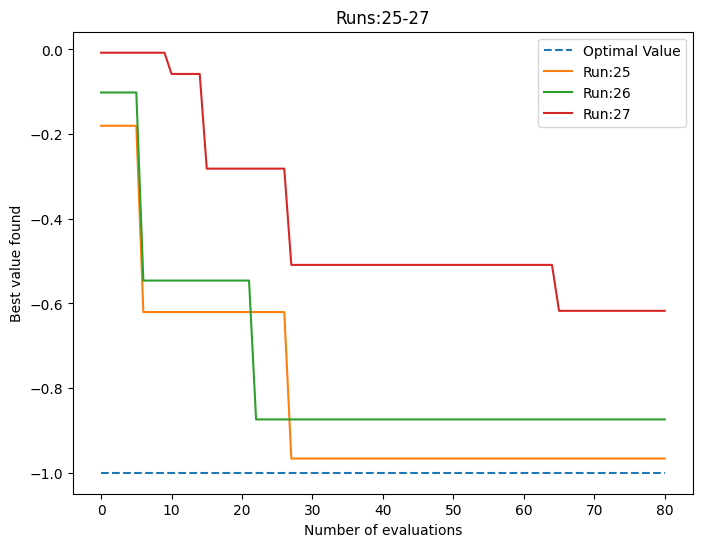

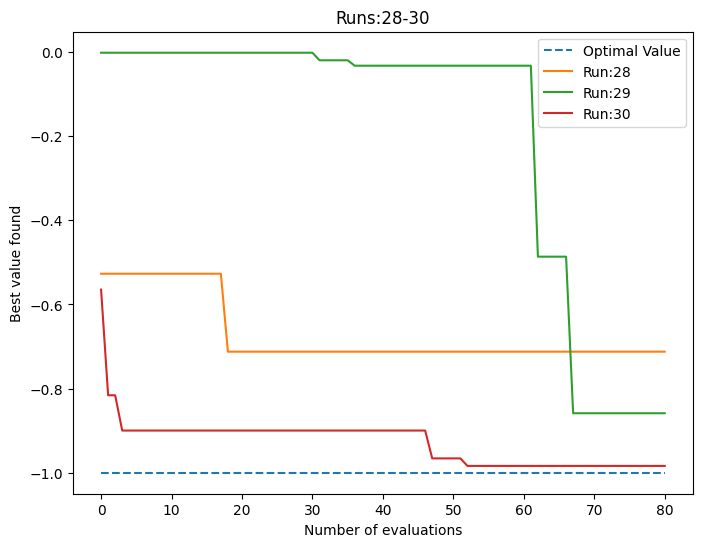

In [4]:
best_values=[]
result_reals=[]
runs=30
for i in tqdm(range(runs)):
  # Set SEED
  SEED=i
  torch.manual_seed(SEED)
  torch.cuda.manual_seed_all(SEED)
  d=2

  # Initial xt and yt
  Init_num=10*d
  sobol= SobolEngine(dimension=d, scramble=True)
  xt = sobol.draw(Init_num).to(dtype=torch.float64,device=torch.device("cuda:0"))
  xt[:,0]=xt[:,0]*(bounds[1][0]-bounds[0][0])+bounds[0][0]
  xt[:,1]=xt[:,1]*(bounds[1][1]-bounds[0][1])+bounds[0][1]
  yt=f(xt,noise)
  yr=f(xt,0)

  # Records
  result_real=[val.item() for val in yr]
  result_noise=[val.item() for val in yt]
  best_value=[-max(result_real)]

  # Budget
  budget=40*d

  # Sampler
  sampler = SobolQMCNormalSampler(torch.Size([1024]))

  # Mean & Kernel
  mean_fn = gpytorch.means.ConstantMean()
  kernel_fn = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

  # Loop
  for j in tqdm(range(budget)):
    # GP Model
    gp_1=SingleTaskGP(train_X=xt,
                      train_Y=yt,
                      input_transform=Normalize(d=d),
                      outcome_transform=Standardize(m=1),
                      mean_module=mean_fn,
                      covar_module=kernel_fn)
    # Fit
    fit_gpytorch_mll(ExactMarginalLogLikelihood(gp_1.likelihood, gp_1))

    # Acquisition Function
    acf=qKnowledgeGradient(model=gp_1,num_fantasies=128)

    # next train_X
    with warnings.catch_warnings():
      warnings.filterwarnings('ignore', category=RuntimeWarning)
      candidate, acq_value = optimize_acqf(acf, bounds=bounds, q=1, num_restarts=20, raw_samples=50,options={"dtype": torch.float64})
      candidate = candidate.to(**tkwargs)

    # List of train_X
    xt= torch.cat([xt, candidate], dim=0)

    # next train_Y & next real_Y
    yr_next = f(candidate,0)
    yt_next = f(candidate,noise)

    # List of train_Y
    yt = torch.cat([yt, yt_next])

    # List of train_Y & List of real_Y
    result_noise.append(yt_next.squeeze(-1).item())
    result_real.append(yr_next.squeeze(-1).item())
    best_value.append(-max(result_real))
  # Update Records
  result_reals.append(result_real)
  best_values.append(best_value)

  # Plot
  iter_num=[k for k in range(0, budget+1)]
  min=[optimal_value for k in range(0, budget+1)]
  if i%3 == 0:
    plt.figure(figsize=(8, 6))
    plt.xlabel("Number of evaluations")
    plt.ylabel("Best value found")
    plt.title(f"Runs:{i+1}-{i+1+2}")
    plt.plot(iter_num,min,'--',label='Optimal Value')
  plt.plot(iter_num,best_value,label=f'Run:{i+1}')
  plt.legend(loc='upper right',)

  # Print
#   print(result_real)
# print(result_reals)
with open('result_reals_Easom+qKG+ConstantMean+RBF.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(best_values)